### Amazon Book Reviews: Review of the top 50 reviewers: Clustering Part III

The original dataset has ~9 million reviews: http://jmcauley.ucsd.edu/data/amazon/.  I have created a subset which contains data of reviewers who have done maximum number of reviews. I did an EDA on the dataset in part I of this notebook. I noticed that some reviewers sound like a corporate name, e.g., Midwest Book Reviews whereas others are individual personnel, e.g., Harriet Klausner. In part II, I looked at clustering of corporate and individuals based on their review texts. Here I am going to look at reviewer segmentations without categorizing corporate/individual labels. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('top50reviews.csv')

In [3]:
df.tail(2)

,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary
128756,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",0439895294,241,252,2007-09-30 00:00:00 UTC,There are some books that come across my plate...,1622,5,Beautiful doesn't even cover it
128757,A22RY8N8CNDF3A,"Loyd E. Eskildson ""Pragmatist""",0061429252,464,510,2011-09-20 00:00:00 UTC,"Suskind's ""Confidence Men"" is based on 746 hou...",1078,5,Objective Look at Presidential Leadership


#### I have created to more tables for book titles and their ranks from review metadata. Here I am going to merge them with the top 50 reviewer data. 

In [4]:
df1 = pd.read_csv("book_titles_new.csv")
df1.head(1)

,asin,title
0,0001048791,"The Crucible: Performed by Stuart Pankin, Jero..."


In [5]:
df = df.merge(df1, on ='asin')
df.tail(2)

,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary,title
128756,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",0307338312,220,248,2008-02-24 00:00:00 UTC,Deepak Chopra's new book is not quite as contr...,312,3,Is Jesus just an Enlightened Master?,The Third Jesus: The Christ We Cannot Ignore
128757,A14OJS0VWMOSWO,Midwest Book Review,0895949903,248,251,2001-03-12 00:00:00 UTC,The Herbal Medicine-Makers Handbook blends the...,58,5,Far more in-depth than your usual herbal recip...,The Herbal Medicine-Maker's Handbook: A Home M...


In [6]:
df2 = pd.read_csv("books_rank_cleaned.csv")
df2.head(1)

,Unnamed: 0,asin,rank
0,0,0001048791,6334800.0


In [7]:
df2 = df2.drop("Unnamed: 0", axis =1)

In [8]:
df2.head(1)

,asin,rank
0,0001048791,6334800.0


In [9]:
df = df.merge(df2, on ='asin')
df.tail(2)

,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary,title,rank
128756,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",0307338312,220,248,2008-02-24 00:00:00 UTC,Deepak Chopra's new book is not quite as contr...,312,3,Is Jesus just an Enlightened Master?,The Third Jesus: The Christ We Cannot Ignore,461913.0
128757,A14OJS0VWMOSWO,Midwest Book Review,0895949903,248,251,2001-03-12 00:00:00 UTC,The Herbal Medicine-Makers Handbook blends the...,58,5,Far more in-depth than your usual herbal recip...,The Herbal Medicine-Maker's Handbook: A Home M...,8306.0


In [10]:
dr = df[df.totalVote > 1] # Total vote at least 2
len(dr)

81639

In [230]:
dr1 = dr.sample(n = 10000) # took a sample of 10,000 entries
dr1.head(1)

,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary,title,rank
72584,AHUT55E980RDR,Neal C. Reynolds,1421405571,1,2,2012-07-16 00:00:00 UTC,While I have never been in the armed services ...,105,5,Easy to read revelation of exactly what PTSD i...,At War with PTSD: Battling Post Traumatic Stre...,271735.0


Now we will create some functions for text analysis. Some of these codes are from http://brandonrose.org/clustering

In [12]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [13]:
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, KernelPCA

In [14]:
add_text = ["book"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)
stemmer = SnowballStemmer("english")

In [231]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in dr1.summary:
    allwords_stemmed = tokenize_and_stem(i) 
    totalvocab_stemmed.extend(allwords_stemmed) 

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = vocab_frame.drop(add_text)
vocab_frame.head()

,words
easi,easy
to,to
read,read
revel,revelation
of,of


In [232]:
vocab_frame.shape

(63926, 1)

In [233]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=5000,
                                     min_df=0.0, stop_words=set(my_stop_words),
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [234]:
%time tfidf_matrix_all_words = tfidf_vectorizer.fit_transform(dr1.summary) 

Wall time: 4.25 s


In [235]:
tfidf_matrix_all_words

<10000x5000 sparse matrix of type '<type 'numpy.float64'>'
	with 44305 stored elements in Compressed Sparse Row format>

In [236]:
terms_all = tfidf_vectorizer.get_feature_names()
terms_all[:10]

[u"'d",
 u"'m",
 u"'s",
 u"'s 's",
 u"'s best",
 u"'s best friend",
 u"'s best work",
 u"'s better",
 u"'s day",
 u"'s dream"]

In [238]:
tfidf_vocab_all = tfidf_vectorizer.vocabulary_
tfidf_vocab_all = pd.DataFrame(tfidf_vocab_all.items(), columns = ['term', 'freq'])
tfidf_vocab_all.sort_values(by = 'freq', ascending = False)[:10]

,term,freq
106,zoo,4999
1717,zone,4998
762,zombi,4997
3906,zani,4996
2041,yummi,4995
751,youth,4994
4796,younger,4993
1905,young teen,4992
3568,young reader,4991
2942,young man,4990


In [239]:
tfidf_matrix_all_words_dense = tfidf_matrix_all_words.todense()
tfidf_matrix_all_words_dense

matrix([[ 0.        ,  0.        ,  0.22082029, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [240]:
%time pca = PCA(n_components=2).fit(tfidf_matrix_all_words_dense)
data2D = pca.transform(tfidf_matrix_all_words_dense)

Wall time: 4.87 s


In [241]:
frame2D = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], reviewer=dr1.reviewerID, title = dr1.title, name = dr1.reviewerName,
                            rank = dr1['rank']))
frame2D.head(3)

,name,rank,reviewer,title,x,y
72584,Neal C. Reynolds,271735.0,AHUT55E980RDR,At War with PTSD: Battling Post Traumatic Stre...,0.070632,-0.021595
76336,"Lollipops ""lollipops5""",630133.0,ATFRPYKXCCTJX,Where the Trail Ends (American Tapestries seri...,-0.021087,-0.005261
56937,Bookreporter,12988.0,A2F6N60Z96CAJI,Inherent Vice: A Novel,-0.020602,-0.005471


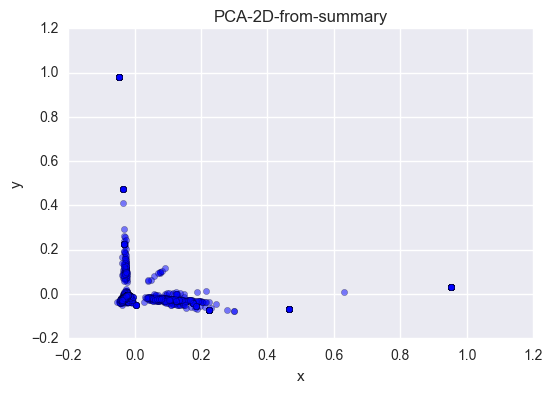

In [242]:
plt.scatter(frame2D.x, frame2D.y, alpha = 0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("PCA-2D-from-summary")

#### optimal number of dimension 

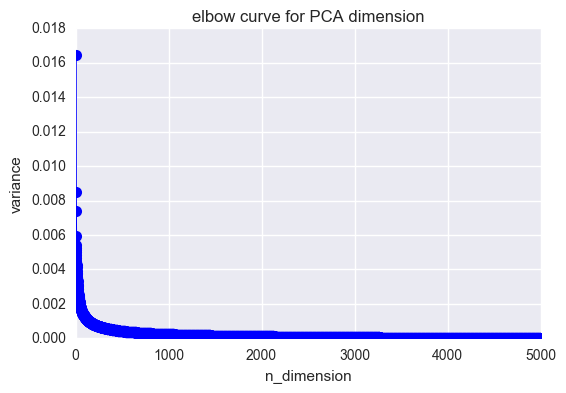

In [243]:
pca1 = PCA().fit(tfidf_matrix_all_words_dense)
variance = pca1.explained_variance_
plt.plot(variance, 'bo-', markersize=8)
plt.xlabel("n_dimension")
plt.ylabel("variance")
plt.title("elbow curve for PCA dimension")

### Optimal number of clusters

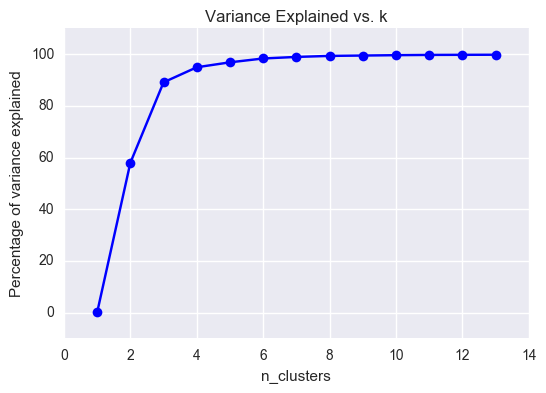

In [245]:
import numpy as np
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(data2D) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(data2D, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(data2D)**2)/data2D.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'bo-')
ax.set_ylim((-10,110))
#plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')

In [252]:
frame2D ['clusterID'] = k_means.fit_predict(data2D)
frame2D.head(3)

,name,rank,reviewer,title,x,y,clusterID
72584,Neal C. Reynolds,271735.0,AHUT55E980RDR,At War with PTSD: Battling Post Traumatic Stre...,0.070632,-0.021595,3
76336,"Lollipops ""lollipops5""",630133.0,ATFRPYKXCCTJX,Where the Trail Ends (American Tapestries seri...,-0.021087,-0.005261,0
56937,Bookreporter,12988.0,A2F6N60Z96CAJI,Inherent Vice: A Novel,-0.020602,-0.005471,0


#### Number of reviewers in each cluster

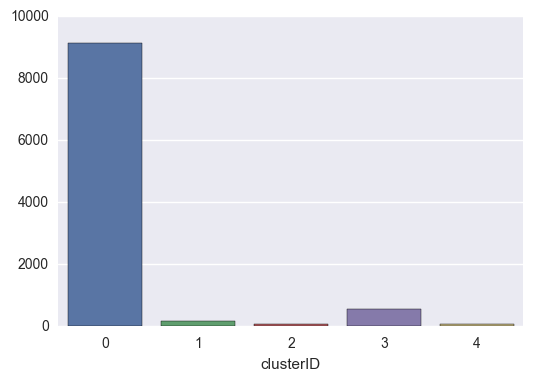

In [253]:
a = frame2D.groupby('clusterID').size()
sns.barplot(a.index, a)

In [255]:
centroids = k_means.cluster_centers_
#centroids_ts = pca.transform(centroids)

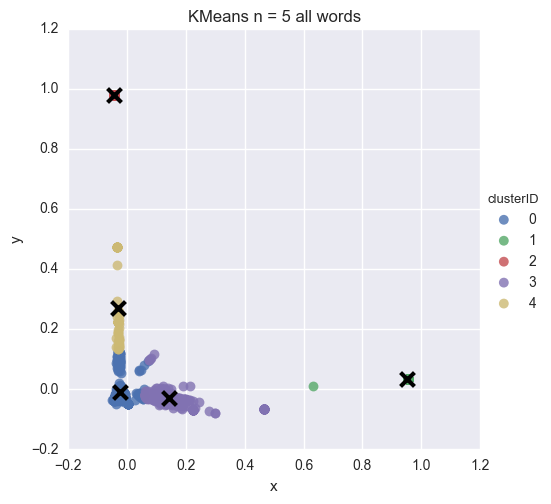

In [256]:
sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=frame2D, fit_reg= False, scatter_kws={"s": 50}) 
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=100, linewidths=3)
plt.title ("KMeans n = 5 all words")

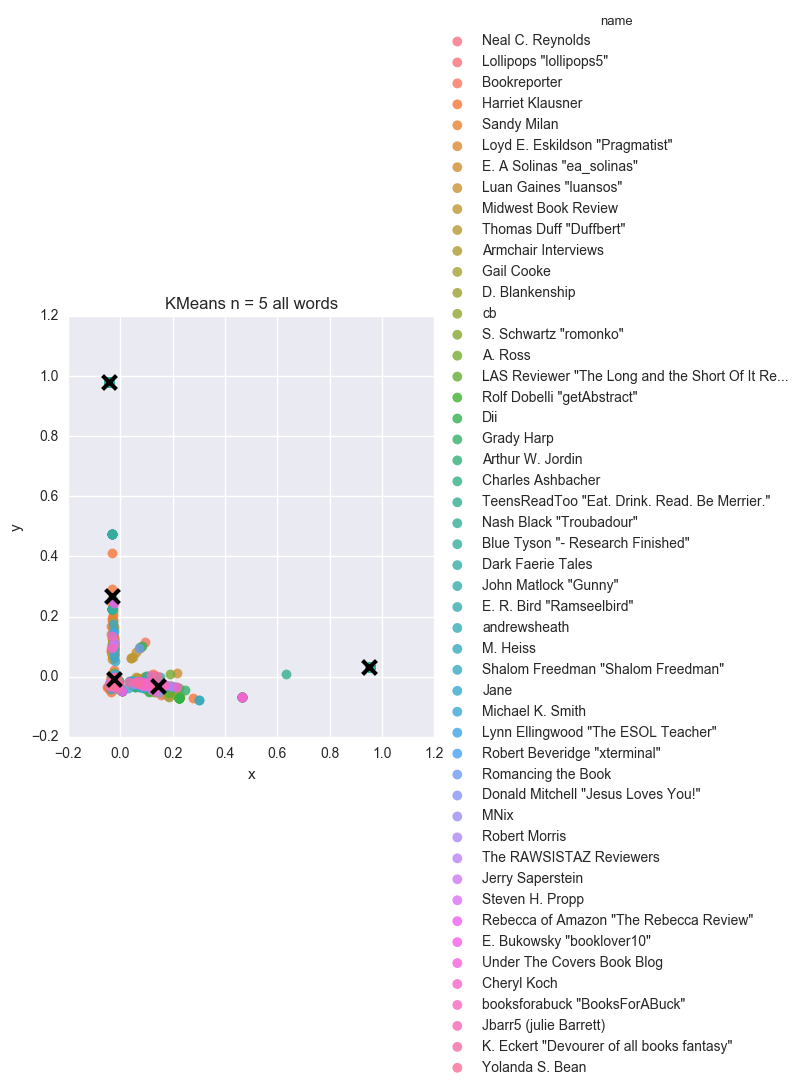

In [258]:
sns.lmplot(x = 'x', y = 'y', hue = "name", data=frame2D, fit_reg= False, scatter_kws={"s": 50}) 
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=100, linewidths=3)
plt.title ("KMeans n = 5 all words")

In [54]:
dense = tfidf_matrix_all_words_dense
len(dense[0].tolist()[0])
review_dense = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(review_dense)), review_dense)]
len(phrase_scores)

5000

In [57]:
top_numbers = 100
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
top_words = []
top_score = []
top =[]
for phrase, score in [(terms_all[word_id], score) 
    for (word_id, score) in sorted_phrase_scores][:top_numbers]:
        #print('{0: <20} {1}'.format(phrase, round(score,5)))
        top.append({'Feature_Name':phrase, 'Score':score})
        top_words.append(phrase)
        top_score.append(int(score*100))

top_score_1 = pd.DataFrame(top)
top_score_1.sort_values(by = "Score", ascending = False)[:10]

,Feature_Name,Score
0,concis,0.531186
1,technolog,0.499469
2,overview,0.485904
3,altern,0.481943
53,4-wheel,0.000000
65,87th,0.000000
74,`it,0.000000
73,`if,0.000000
72,`grump,0.000000
71,`get,0.000000


In [59]:
vocab = ["romance", "mystery", "drama", "fiction", "teen", "teens", "biography", "story", "tale", "animal", "family", "fun", 
         "horror", "comedy", "action", "classic", "crime", "fantasy", "humor", "children", "kid", "families","conceptual",
        "innovation", "traumas", "style", "fashion", "social", "issues", "collection", "science", "period", "photographs",
        "historical", "murder", "suspenseful", "suspence", "inspirational", "graphic", "instructions", "thriller", "adventure",
        "western", "textbook", "legal", "action-packed", "career", "information", "contemporary",
        "mature", "adult", "military", "marine", "cops", "agriculture", "history", "photography","academic", "academy",
        "geography", "myth", "mythology", "paranormal", "essay", "self-help", "memoir", "autobiography", 
         "romantic", "fairy tale", "science fiction", "religion", "jesus"]
#vocab = ["romance"]
tfidf_vectorizer_genre = TfidfVectorizer(#max_df=1.0, max_features=5000,
                                     #min_df=0.0, 
                                        stop_words=set(my_stop_words),
                                     use_idf=True, 
                            tokenizer=tokenize_and_stem, ngram_range=(1, 3), vocabulary = vocab)
%time tfidf_matrix_genre = tfidf_vectorizer_genre.fit_transform(dr1.summary) 

Wall time: 3.99 s


In [60]:
tfidf_matrix_genre

<10000x72 sparse matrix of type '<type 'numpy.float64'>'
	with 1910 stored elements in Compressed Sparse Row format>

In [62]:
genre = tfidf_vectorizer_genre.get_feature_names()
genre[:10]

['romance',
 'mystery',
 'drama',
 'fiction',
 'teen',
 'teens',
 'biography',
 'story',
 'tale',
 'animal']

In [66]:
tfidf_vocab_genre = tfidf_vectorizer_genre.vocabulary_
tfidf_vocab_genre = pd.DataFrame(tfidf_vocab_genre.items(), columns = ['term', 'freq'])
tfidf_vocab_genre = tfidf_vocab_genre.sort_values(by = 'freq', ascending = False)
tfidf_vocab_genre.reset_index()[:10]

,index,term,freq
0,4,jesus,71
1,47,religion,70
2,30,science fiction,69
3,14,fairy tale,68
4,28,romantic,67
5,43,autobiography,66
6,53,memoir,65
7,6,self-help,64
8,0,essay,63
9,31,paranormal,62


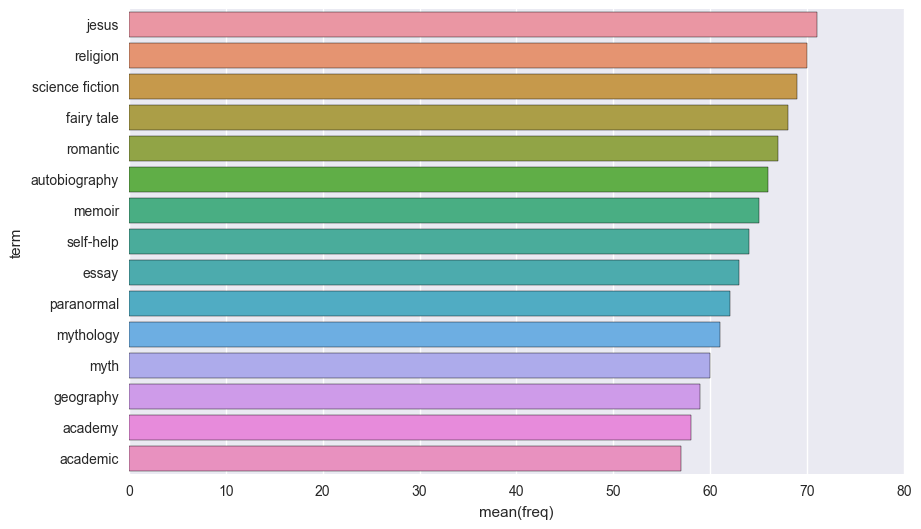

In [75]:
plt.figure(figsize= [10, 6])
a = tfidf_vocab_genre[:15]
sns.barplot(a.freq, a.term)
#a

In [154]:
tfidf_matrix_genre_dense = tfidf_matrix_genre.todense()
tfidf_matrix_genre_dense

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [155]:
%time pca = PCA(n_components=2).fit(tfidf_matrix_genre_dense)
data2D_genre = pca.transform(tfidf_matrix_genre_dense)

Wall time: 105 ms


In [156]:
frame2D_genre = pd.DataFrame(dict(x=data2D_genre[:,0], y=data2D_genre[:,1], reviewer=dr1.reviewerID, 
                                  title = dr1.title, name = dr1.reviewerName, rank = dr1['rank']))
frame2D_genre.head(3)

,name,rank,reviewer,title,x,y
111157,Midwest Book Review,1772357.0,A14OJS0VWMOSWO,IT Architectures and Middleware: Strategies fo...,-0.037332,-0.025291
109370,M. Heiss,49636.0,A13G1TKIKHGV3F,Triumph of the City: How Our Greatest Inventio...,-0.037332,-0.025291
27880,Harriet Klausner,912849.0,AFVQZQ8PW0L,Nightmare in Shining Armor: A Den of Antiquity...,-0.037332,-0.025291


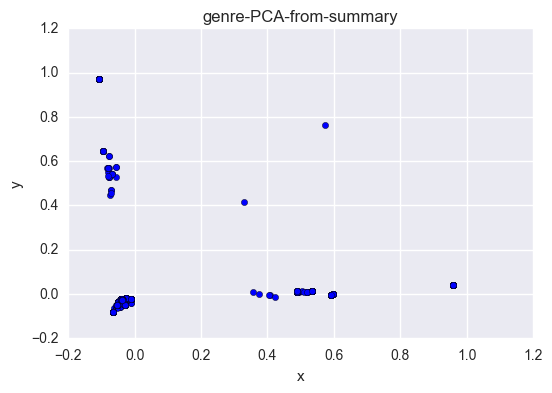

In [157]:
plt.scatter(frame2D_genre.x, frame2D_genre.y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("genre-PCA-from-summary")

Optimal number of PCA dimension can be obtained by looking at explained variance

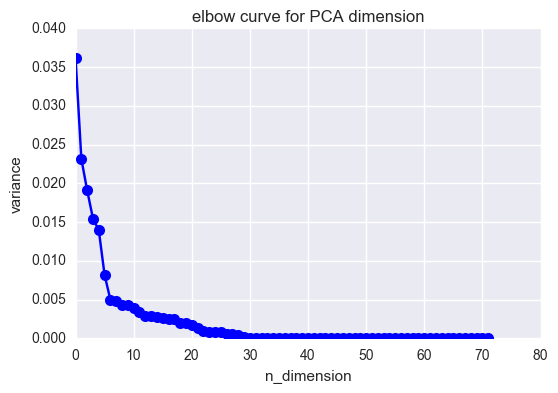

In [158]:
pca1 = PCA().fit(tfidf_matrix_genre_dense)
variance = pca1.explained_variance_
plt.plot(variance, 'bo-', markersize=8)
plt.xlabel("n_dimension")
plt.ylabel("variance")
plt.title("elbow curve for PCA dimension")

### Optimal number of clusters

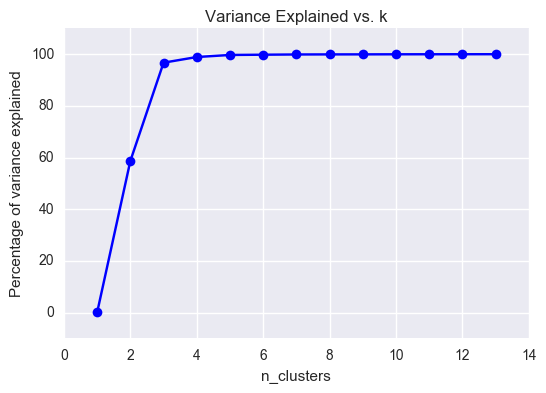

In [159]:
import numpy as np
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Determine your k range
k_range = range(1,14)

# Fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(data2D_genre) for k in k_range]

# Pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculate the Euclidean distance from 
# each point to each cluster center
k_euclid = [cdist(data2D_genre, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# The total sum of squares
tss = sum(pdist(data2D_genre)**2)/data2D_genre.shape[0]

# The between-cluster sum of squares
bss = tss - wcss

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, 'bo-')
#ax.set_ylim((0,100))
#plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Variance Explained vs. k')
plt.ylim([-10, 110])
plt.show()

In [293]:
k_means = KMeans(n_clusters = 5, n_init =25)
k_means.fit_predict(data2D_genre)

array([0, 0, 0, ..., 0, 0, 0])

In [294]:
frame2D_genre ['clusterID'] = k_means.fit_predict(data2D_genre)
frame2D_genre.head(3)

,name,rank,reviewer,title,x,y,clusterID
59176,Armchair Interviews,1193978.0,A21NVBFIEQWDSG,A Widow's Curse: A Fever Devilin Novel,-0.039679,-0.026223,0
66054,"Rolf Dobelli ""getAbstract""",347036.0,A1NATT3PN24QWY,Economic Facts and Fallacies,-0.039679,-0.026223,0
77025,The RAWSISTAZ Reviewers,1322785.0,A2VKWLCNZF4ZVB,Dark Dreams: A Collection of Horror and Suspen...,-0.039679,-0.026223,0


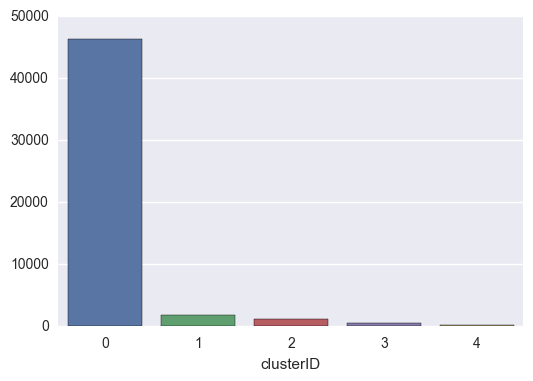

In [295]:
a = frame2D_genre.groupby('clusterID').size()
sns.barplot(a.index, a)

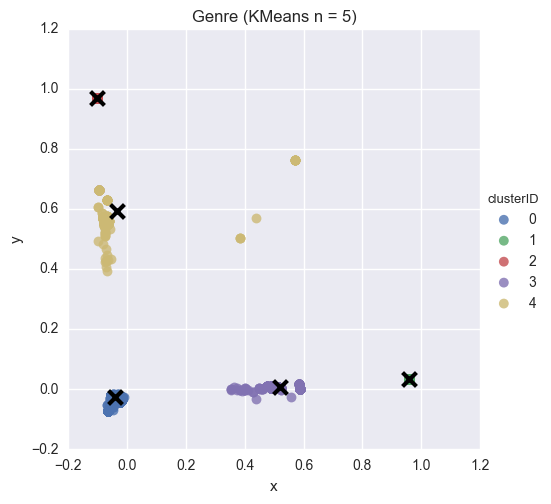

In [296]:
centroids_genre = k_means.cluster_centers_
#centroids_ts = pca.transform(centroids_genre)
sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=frame2D_genre, fit_reg= False, scatter_kws={"s": 50}) 
plt.scatter(centroids_genre[:, 0], centroids_genre[:, 1], marker = "x", color = 'k', s=100, linewidths=3)
plt.title ("Genre (KMeans n = 5)")

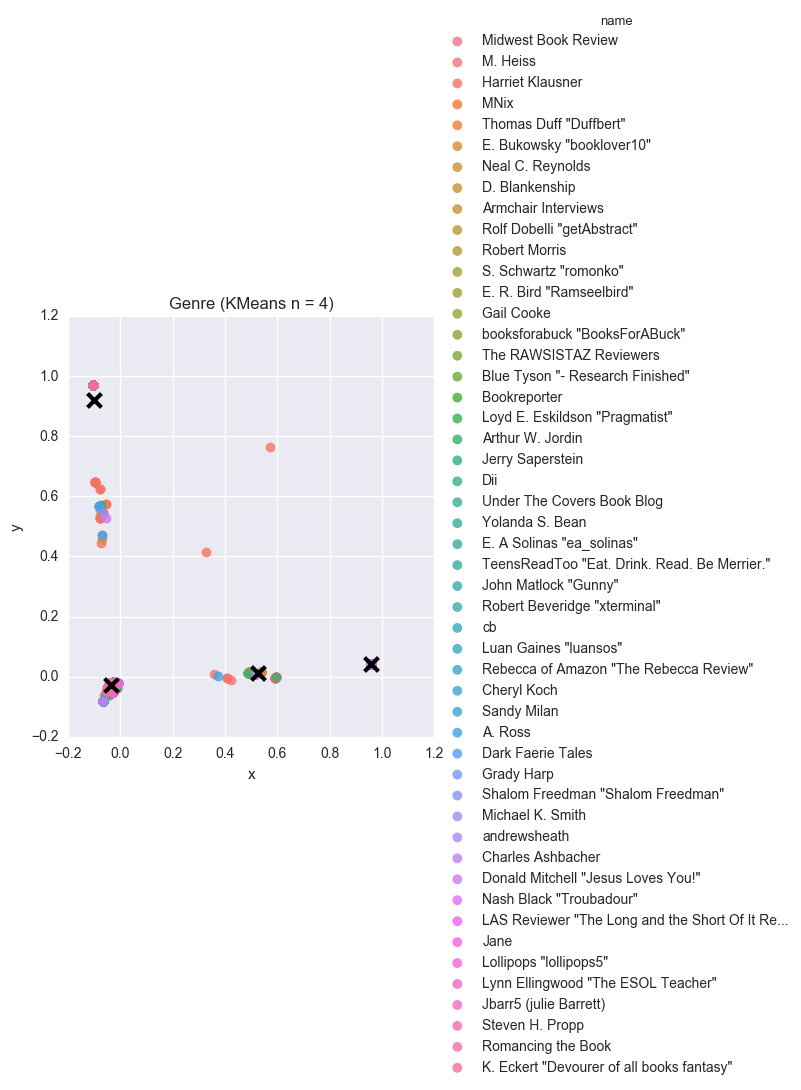

In [267]:
sns.lmplot(x = 'x', y = 'y', hue = "name", data=frame2D_genre, fit_reg= False, scatter_kws={"s": 50}) 
plt.scatter(centroids_genre[:, 0], centroids_genre[:, 1], marker = "x", color = 'k', s=100, linewidths=3)
plt.title ("Genre (KMeans n = 4)")

#### We can make a function which would plot 2D clusters from a summary texts. We will supply the vocabulary of genre words.

In [277]:
vocab = ["romance", "mystery", "drama", "fiction", "teen", "teens", "biography", "story", "tale", "animal", "family", "fun", 
         "horror", "comedy", "action", "classic", "crime", "fantasy", "humor", "children", "kid", "families","conceptual",
        "innovation", "traumas", "style", "fashion", "social", "issues", "collection", "science", "period", "photographs",
        "historical", "murder", "suspenseful", "suspence", "inspirational", "graphic", "instructions", "thriller", "adventure",
        "western", "textbook", "legal", "action-packed", "career", "information", "contemporary",
        "mature", "adult", "military", "marine", "cops", "agriculture", "history", "photography","academic", "academy",
        "geography", "myth", "mythology", "paranormal", "essay", "self-help", "memoir", "autobiography", 
         "romantic", "fairy tale", "science fiction", "religion", "jesus"]
#vocab = ["romance"]

def summary_cluster (dataframe, n_clusters):
    
    tfidf_vectorizer_test = TfidfVectorizer(#max_df=1.0, max_features=5000,
                                         #min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 3), vocabulary = vocab)
    tfidf_matrix_test = tfidf_vectorizer_test.fit_transform(dataframe.summary) 
    
    genre = tfidf_vectorizer_test.get_feature_names()
    
    print ("Number of features:")
    print (len(tfidf_vectorizer_test.get_feature_names()))
    print ("")
    print ("feature examples:") 
    print (genre[:10])  
    print ("")
    print ("")
    tfidf_vocab_genre = tfidf_vectorizer_test.vocabulary_
    tfidf_vocab_genre = pd.DataFrame(tfidf_vocab_genre.items(), columns = ['term', 'freq'])
    tfidf_vocab_genre = tfidf_vocab_genre.sort_values(by = 'freq', ascending = False)
    
    print ("top ten terms in review summaries:")
    print ("")
    print (tfidf_vocab_genre[:10])
    print ("")
    
    tfidf_matrix_test_dense = tfidf_matrix_test.todense()
    pca = PCA(n_components=2).fit(tfidf_matrix_test_dense)
    data2D_genre = pca.transform(tfidf_matrix_test_dense)
    
    frame2D_genre = pd.DataFrame(dict(x=data2D_genre[:,0], y=data2D_genre[:,1], reviewer=dataframe.reviewerID, 
                                  title = dataframe.title, name = dataframe.reviewerName, rank = dataframe['rank']))
    
    k_means = KMeans(n_clusters = n_clusters, n_init = 50)
    frame2D_genre ['clusterID'] = k_means.fit_predict(data2D_genre)
    
    print ("Number items in each cluster:")
    print (frame2D_genre.clusterID.value_counts())
    print ("")
    print ("")
    
    centroids_genre = k_means.cluster_centers_
    #centroids_ts = pca.transform(centroids_genre)
    sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=frame2D_genre, fit_reg= False, scatter_kws={"s": 50}) 
    plt.scatter(centroids_genre[:, 0], centroids_genre[:, 1], marker = "x", color = 'k', s=100, linewidths=3)
    plt.title ("n = " + str(n_clusters))
    plt.show()

Number of features:
72

feature examples:
['romance', 'mystery', 'drama', 'fiction', 'teen', 'teens', 'biography', 'story', 'tale', 'animal']


top ten terms in review summaries:

               term  freq
4             jesus    71
47         religion    70
30  science fiction    69
14       fairy tale    68
28         romantic    67
43    autobiography    66
53           memoir    65
6         self-help    64
0             essay    63
31       paranormal    62

Number items in each cluster:
0    9322
1     341
2     242
3      95
Name: clusterID, dtype: int64




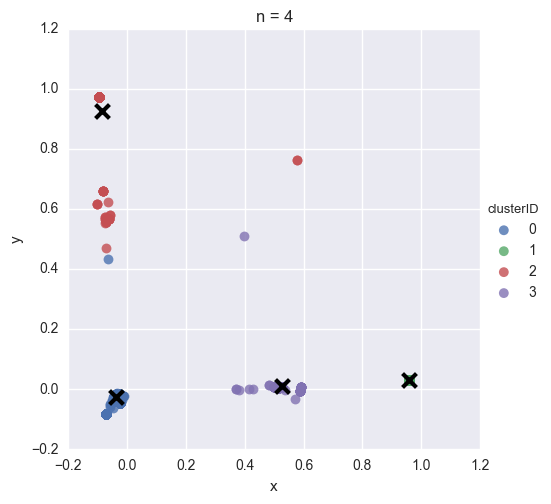

In [272]:
summary_cluster(dr1, 4) # 10,000 samples with 4 clusters

It misses one cluster

Number of features:
72

feature examples:
['romance', 'mystery', 'drama', 'fiction', 'teen', 'teens', 'biography', 'story', 'tale', 'animal']


top ten terms in review summaries:

               term  freq
4             jesus    71
47         religion    70
30  science fiction    69
14       fairy tale    68
28         romantic    67
43    autobiography    66
53           memoir    65
6         self-help    64
0             essay    63
31       paranormal    62

Number items in each cluster:
0    9321
1     341
2     212
3      94
4      32
Name: clusterID, dtype: int64




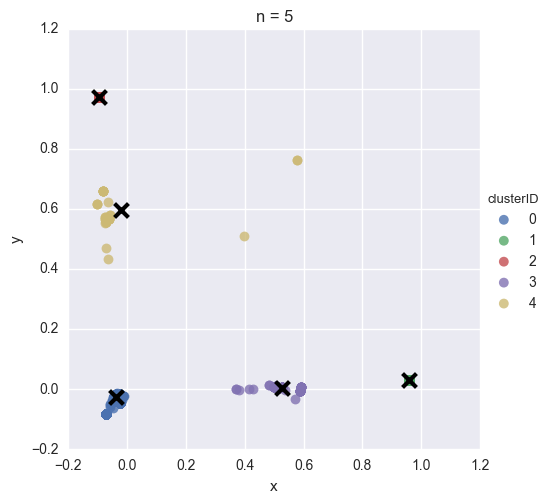

In [273]:
summary_cluster(dr1, 5)

#### We can also make a function which would take review texts as input and clusters as output

In [274]:
def text_cluster (dataframe, n_clusters):
    
    tfidf_vectorizer_test = TfidfVectorizer(#max_df=1.0, max_features=5000,
                                         #min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 3), vocabulary = vocab)
    tfidf_matrix_test = tfidf_vectorizer_test.fit_transform(dataframe.reviewText) 
    
    genre = tfidf_vectorizer_test.get_feature_names()
    
    print ("Number of features:")
    print (len(tfidf_vectorizer_test.get_feature_names()))
    print ("")
    print ("features example:") 
    print (genre[:10])  
    print ("")
    print ("")
    tfidf_vocab_genre = tfidf_vectorizer_test.vocabulary_
    tfidf_vocab_genre = pd.DataFrame(tfidf_vocab_genre.items(), columns = ['term', 'freq'])
    tfidf_vocab_genre = tfidf_vocab_genre.sort_values(by = 'freq', ascending = False)
    
    print ("top ten terms in review texts:")
    print ("")
    print (tfidf_vocab_genre[:10])
    print ("")
    
    tfidf_matrix_test_dense = tfidf_matrix_test.todense()
    pca = PCA(n_components=2).fit(tfidf_matrix_test_dense)
    data2D_genre = pca.transform(tfidf_matrix_test_dense)
    
    frame2D_genre = pd.DataFrame(dict(x=data2D_genre[:,0], y=data2D_genre[:,1], reviewer=dataframe.reviewerID, 
                                  title = dataframe.title, name = dataframe.reviewerName, rank = dataframe['rank']))
    
    k_means = KMeans(n_clusters = n_clusters, n_init = 50)
    frame2D_genre ['clusterID'] = k_means.fit_predict(data2D_genre)
    
    print ("Number items in each cluster:")
    print (frame2D_genre.clusterID.value_counts())
    print ("")
    print ("")
    
    centroids_genre = k_means.cluster_centers_
    #centroids_ts = pca.transform(centroids_genre)
    sns.lmplot(x = 'x', y = 'y', hue = "clusterID", data=frame2D_genre, fit_reg= False, scatter_kws={"s": 50}) 
    plt.scatter(centroids_genre[:, 0], centroids_genre[:, 1], marker = "x", color = 'k', s=100, linewidths=3)
    plt.title ("n = " + str(n_clusters))
    plt.show()

Number of features:
72

features example:
['romance', 'mystery', 'drama', 'fiction', 'teen', 'teens', 'biography', 'story', 'tale', 'animal']


top ten terms in review texts:

               term  freq
4             jesus    71
47         religion    70
30  science fiction    69
14       fairy tale    68
28         romantic    67
43    autobiography    66
53           memoir    65
6         self-help    64
0             essay    63
31       paranormal    62

Number items in each cluster:
0    7437
2    1030
1     931
3     602
Name: clusterID, dtype: int64




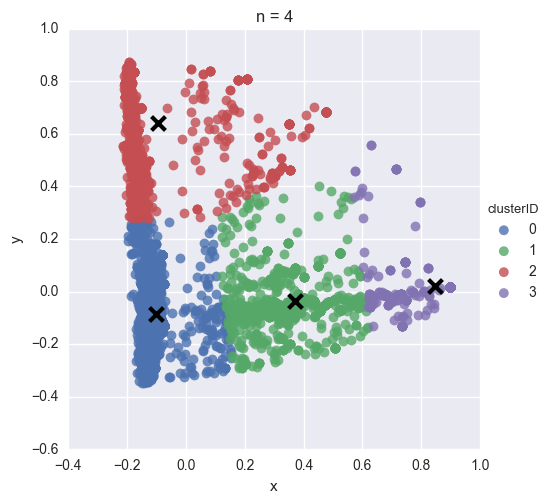

In [275]:
text_cluster(dr1, 4)

Number of features:
72

features example:
['romance', 'mystery', 'drama', 'fiction', 'teen', 'teens', 'biography', 'story', 'tale', 'animal']


top ten terms in review texts:

               term  freq
4             jesus    71
47         religion    70
30  science fiction    69
14       fairy tale    68
28         romantic    67
43    autobiography    66
53           memoir    65
6         self-help    64
0             essay    63
31       paranormal    62

Number items in each cluster:
1    7142
0     899
5     593
3     587
2     575
4     204
Name: clusterID, dtype: int64




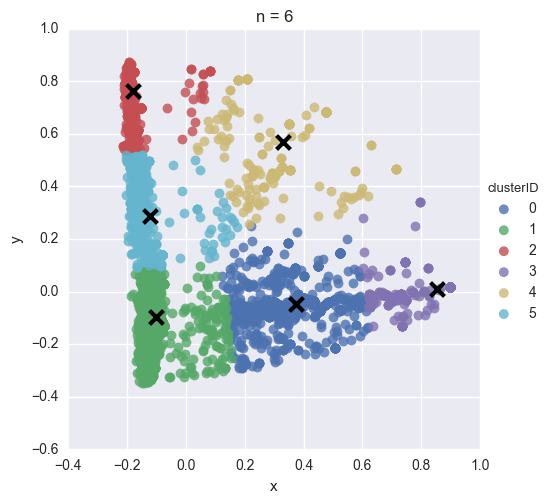

In [276]:
text_cluster(dr1, 6)

#### We can take more samples and run the analysis with summary texts

In [282]:
dr2 = dr.sample(n = 50000)
len(dr2)

50000

Number of features:
72

feature examples:
['romance', 'mystery', 'drama', 'fiction', 'teen', 'teens', 'biography', 'story', 'tale', 'animal']


top ten terms in review summaries:

               term  freq
4             jesus    71
47         religion    70
30  science fiction    69
14       fairy tale    68
28         romantic    67
43    autobiography    66
53           memoir    65
6         self-help    64
0             essay    63
31       paranormal    62

Number items in each cluster:
0    46398
1     1813
2     1115
3      485
4      189
Name: clusterID, dtype: int64




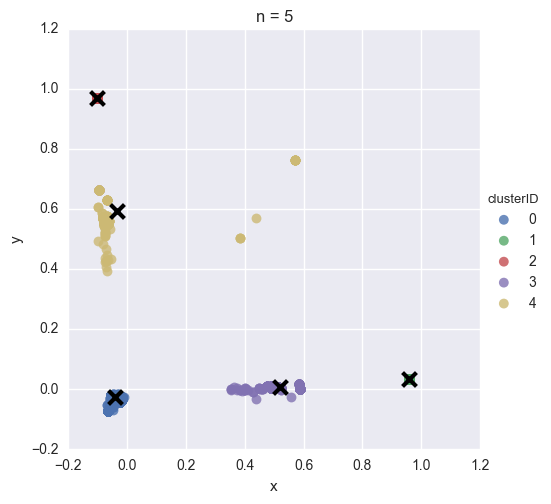

In [279]:
summary_cluster(dr2, 5)

### Let's look at top words per clusters, respective reviewers and books

In [185]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in dr1.summary:
    allwords_stemmed = tokenize_and_stem(i) 
    totalvocab_stemmed.extend(allwords_stemmed) 

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = vocab_frame.drop(add_text)
vocab_frame.head()

,words
a,a
concis,concise
overview,overview
of,of
middlewar,middleware


In [186]:
tfidf_vectorizer_cluster = TfidfVectorizer(#max_df=1.0, max_features=5000,
                                         #min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 3), vocabulary = vocab)

tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dr1.summary) 
    
terms = tfidf_vectorizer_cluster.get_feature_names()
   
tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()

In [203]:
from sklearn.externals import joblib
from __future__ import print_function

num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=20)
print ("K-means fit:") 
%time km.fit(tfidf_matrix_cluster)
clusters = km.labels_.tolist()

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
dr1['clusterName'] = clusters
print()
print ("Number of items in each cluster:")
print (dr1.clusterName.value_counts())
dr1 = dr1.set_index('clusterName')
print()
print("Top terms per cluster:")
print()
    
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        
for i in range(num_clusters):
    print("Cluster %d top words:" % i, end='')

    for ind in order_centroids[i, :4]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

    print("Cluster %d reviewers:" % i, end='')
    for reviewer in dr1.ix[i]['reviewerName'].unique():
        print(' %s,' % reviewer, end='')
    print() #add whitespace
    print() #add whitespace

    print("Cluster %d books:" % i, end='')
    for book in dr1.ix[i]['title'][:20]:
        print(' %s,' % book, end='')
    print() #add whitespace
    print() #add whitespace

print()
print()

K-means fit:
Wall time: 706 ms

Number of items in each cluster:
0    8957
2     422
4     250
1     210
3     161
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: fiction, drama, humor, action,

Cluster 0 reviewers: Midwest Book Review, M. Heiss, Harriet Klausner, MNix, Thomas Duff "Duffbert", E. Bukowsky "booklover10", Neal C. Reynolds, D. Blankenship, Armchair Interviews, Rolf Dobelli "getAbstract", Robert Morris, S. Schwartz "romonko", E. R. Bird "Ramseelbird", booksforabuck "BooksForABuck", The RAWSISTAZ Reviewers, Blue Tyson "- Research Finished", Bookreporter, Loyd E. Eskildson "Pragmatist", Gail Cooke, Arthur W. Jordin, Jerry Saperstein, Dii, Under The Covers Book Blog, E. A Solinas "ea_solinas", John Matlock "Gunny", Robert Beveridge "xterminal", cb, Luan Gaines "luansos", Rebecca of Amazon "The Rebecca Review", Cheryl Koch, Sandy Milan, A. Ross, Dark Faerie Tales, Grady Harp, Shalom Freedman "Shalom Freedman", Michael K. Smith, andrewsheath, Charl

In [288]:
from sklearn.externals import joblib
from __future__ import print_function

def summary_top_words (dataframe, n_clusters):
    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in dataframe.summary:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(#max_df=1.0, max_features=5000,
                                         #min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 3), vocabulary = vocab)

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.summary) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    km = KMeans(n_clusters=n_clusters, random_state= 123, n_init=20)
    print ("K-means fit:") 
    %time km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster.pkl')
    km = joblib.load('doc_cluster.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of items in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :4]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d reviewers:" % i, end='')
        for reviewer in dataframe.ix[i]['reviewerName'].unique():
            print(' %s,' % reviewer, end='')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'][:20]:
            print(' %s,' % book, end='')
        print() #add whitespace
        print() #add whitespace

    print()
    print()

In [284]:
summary_top_words(dr1, 5) # 10,000 review summary, 5 clusters and 5 top words

K-means fit:
Wall time: 400 ms

Number of items in each cluster:
0    8987
1     419
3     232
2     185
4     177
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: fiction, drama, humorous, memoir,

Cluster 0 reviewers: Neal C. Reynolds, Lollipops "lollipops5", Bookreporter, Harriet Klausner, Sandy Milan, Loyd E. Eskildson "Pragmatist", E. A Solinas "ea_solinas", Luan Gaines "luansos", Midwest Book Review, Thomas Duff "Duffbert", Armchair Interviews, Gail Cooke, cb, S. Schwartz "romonko", A. Ross, LAS Reviewer "The Long and the Short Of It Re..., Rolf Dobelli "getAbstract", Dii, Grady Harp, Arthur W. Jordin, Charles Ashbacher, D. Blankenship, Blue Tyson "- Research Finished", Dark Faerie Tales, John Matlock "Gunny", E. R. Bird "Ramseelbird", andrewsheath, M. Heiss, Shalom Freedman "Shalom Freedman", Jane, Nash Black "Troubadour", Michael K. Smith, Lynn Ellingwood "The ESOL Teacher", Robert Beveridge "xterminal", Romancing the Book, Donald Mitchell "Jesus Lo

In [285]:
summary_top_words(dr2, 5) #50,000 review summaries, 5 clusters, 4 top words per cluster

K-means fit:
Wall time: 1.75 s

Number of items in each cluster:
0    44830
1     2194
4     1237
3      968
2      771
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: fiction, drama, humorous, action,

Cluster 0 reviewers: Harriet Klausner, Midwest Book Review, D. Blankenship, MNix, E. A Solinas "ea_solinas", Shalom Freedman "Shalom Freedman", Robert Beveridge "xterminal", Donald Mitchell "Jesus Loves You!", Yolanda S. Bean, A. Ross, Charles Ashbacher, Sandy Milan, Arthur W. Jordin, Neal C. Reynolds, Bookreporter, Jane, Robert Morris, The RAWSISTAZ Reviewers, Loyd E. Eskildson "Pragmatist", Under The Covers Book Blog, Lynn Ellingwood "The ESOL Teacher", John Matlock "Gunny", booksforabuck "BooksForABuck", Dii, Gail Cooke, LAS Reviewer "The Long and the Short Of It Re..., Armchair Interviews, Cheryl Koch, Grady Harp, E. Bukowsky "booklover10", Rolf Dobelli "getAbstract", E. R. Bird "Ramseelbird", cb, Rebecca of Amazon "The Rebecca Review", Michael K. Smith

### Function to get top words from review text

In [290]:
from sklearn.externals import joblib
from __future__ import print_function

def text_top_words (dataframe, n_clusters):
    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in dataframe.summary:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(#max_df=1.0, max_features=5000,
                                         #min_df=0.0, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 3), vocabulary = vocab)

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.reviewText) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    km = KMeans(n_clusters=n_clusters, random_state= 123, n_init=20)
    print ("K-means fit:") 
    %time km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster.pkl')
    km = joblib.load('doc_cluster.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of items in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top terms per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :4]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d reviewers:" % i, end='')
        for reviewer in dataframe.ix[i]['reviewerName'].unique():
            print(' %s,' % reviewer, end='')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'][:20]:
            print(' %s,' % book, end='')
        print() #add whitespace
        print() #add whitespace

    print()
    print()

In [291]:
text_top_words(dr1, 5)

K-means fit:
Wall time: 2.34 s

Number of items in each cluster:
0    6637
4    1230
3     993
2     798
1     342
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: action, fun, fiction, style,

Cluster 0 reviewers: Neal C. Reynolds, Bookreporter, Harriet Klausner, Sandy Milan, Loyd E. Eskildson "Pragmatist", E. A Solinas "ea_solinas", Thomas Duff "Duffbert", Armchair Interviews, D. Blankenship, Midwest Book Review, cb, A. Ross, Rolf Dobelli "getAbstract", Dii, Grady Harp, Arthur W. Jordin, LAS Reviewer "The Long and the Short Of It Re..., Charles Ashbacher, TeensReadToo "Eat. Drink. Read. Be Merrier.", Nash Black "Troubadour", Dark Faerie Tales, John Matlock "Gunny", E. R. Bird "Ramseelbird", andrewsheath, M. Heiss, Shalom Freedman "Shalom Freedman", Michael K. Smith, Lynn Ellingwood "The ESOL Teacher", Robert Beveridge "xterminal", Romancing the Book, Blue Tyson "- Research Finished", S. Schwartz "romonko", MNix, Robert Morris, Donald Mitchell "Jesus Loves

In [292]:
text_top_words(dr2, 5)

K-means fit:
Wall time: 13.5 s

Number of items in each cluster:
0    28743
3     6398
1     5723
2     5179
4     3957
Name: clusterName, dtype: int64

Top terms per cluster:

Cluster 0 top words: style, fiction, humorous, social,

Cluster 0 reviewers: Midwest Book Review, MNix, E. A Solinas "ea_solinas", Yolanda S. Bean, Harriet Klausner, Charles Ashbacher, Sandy Milan, Arthur W. Jordin, A. Ross, Robert Morris, Loyd E. Eskildson "Pragmatist", Under The Covers Book Blog, D. Blankenship, Lynn Ellingwood "The ESOL Teacher", John Matlock "Gunny", The RAWSISTAZ Reviewers, LAS Reviewer "The Long and the Short Of It Re..., Bookreporter, Armchair Interviews, E. Bukowsky "booklover10", Shalom Freedman "Shalom Freedman", Rolf Dobelli "getAbstract", cb, Rebecca of Amazon "The Rebecca Review", Donald Mitchell "Jesus Loves You!", Michael K. Smith, Steven H. Propp, Jbarr5 (julie Barrett), Cheryl Koch, Grady Harp, Blue Tyson "- Research Finished", TeensReadToo "Eat. Drink. Read. Be Merrier.", Luan 